In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("aplicacion_filtro.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, bright = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)


result = cv2.bitwise_and(img, img, mask=bright)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Solo cuerpos brillantes")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



Epoch 100 | loss=0.1418 | acc=94.35%
Epoch 200 | loss=0.1403 | acc=94.35%
Epoch 300 | loss=0.1390 | acc=94.40%
Epoch 400 | loss=0.1361 | acc=94.55%


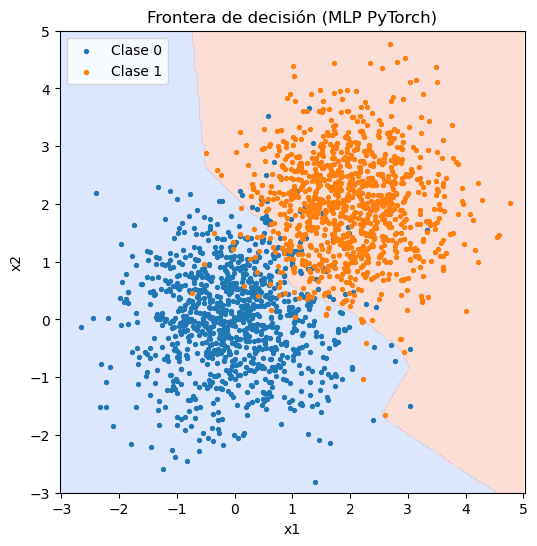

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1) Datos sintéticos: dos “nubes” 2D
torch.manual_seed(0)
n = 1000
mean0 = torch.tensor([0.0, 0.0])
mean1 = torch.tensor([2.0, 2.0])
cov = torch.tensor([[0.8, 0.0],[0.0, 0.8]])

x0 = torch.distributions.MultivariateNormal(mean0, cov).sample((n,))
x1 = torch.distributions.MultivariateNormal(mean1, cov).sample((n,))
X = torch.cat([x0, x1], dim=0)                           # (2000, 2)
y = torch.cat([torch.zeros(n), torch.ones(n)]).long()    # etiquetas 0/1

# 2) Dispositivo (GPU si hay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = X.to(device), y.to(device)

# 3) Modelo MLP simple
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # 2 clases
        )
    def forward(self, x): return self.net(x)

model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-2)

# 4) Entrenamiento
for epoch in range(400):
    opt.zero_grad()
    logits = model(X)
    loss = loss_fn(logits, y)
    loss.backward()
    opt.step()
    if (epoch+1) % 100 == 0:
        pred = logits.argmax(1)
        acc = (pred == y).float().mean().item()
        print(f"Epoch {epoch+1:3d} | loss={loss.item():.4f} | acc={acc*100:.2f}%")

# 5) Visualizar frontera de decisión
model.eval()
with torch.no_grad():
    xs = torch.linspace(-3, 5, 200)
    ys = torch.linspace(-3, 5, 200)
    GX, GY = torch.meshgrid(xs, ys, indexing='xy')
    grid = torch.stack([GX.flatten(), GY.flatten()], dim=1).to(device)
    Z = model(grid).argmax(1).reshape(200, 200).cpu()

plt.figure(figsize=(6,6))
plt.contourf(xs.cpu(), ys.cpu(), Z.cpu(), alpha=0.3, levels=1, cmap="coolwarm")
x0c = X[y==0].detach().cpu()
x1c = X[y==1].detach().cpu()
plt.scatter(x0c[:,0], x0c[:,1], s=8, label="Clase 0")
plt.scatter(x1c[:,0], x1c[:,1], s=8, label="Clase 1")
plt.legend(); plt.title("Frontera de decisión (MLP PyTorch)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.show()


2025-10-16 07:54:42.526792: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 07:54:42.600098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760615682.641676    5514 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760615682.652341    5514 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760615682.715056    5514 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/40


I0000 00:00:1760615686.484149    5697 service.cc:152] XLA service 0x745cfc00abe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760615686.484179    5697 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-10-16 07:54:46.507242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760615686.615218    5697 cuda_dnn.cc:529] Loaded cuDNN version 90800


 1/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.4375 - loss: 0.7488

I0000 00:00:1760615688.613172    5697 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1760615690.090234    5697 buffer_comparator.cc:156] Difference at 0: inf, expected 10.2554
E0000 00:00:1760615690.090261    5697 buffer_comparator.cc:156] Difference at 1: inf, expected 9.42265
E0000 00:00:1760615690.090263    5697 buffer_comparator.cc:156] Difference at 2: inf, expected 5.05137
E0000 00:00:1760615690.090264    5697 buffer_comparator.cc:156] Difference at 3: inf, expected 4.72852
E0000 00:00:1760615690.090265    5697 buffer_comparator.cc:156] Difference at 4: inf, expected 12.2628
E0000 00:00:1760615690.090267    5697 buffer_comparator.cc:156] Difference at 5: inf, expected 11.2408
E0000 00:00:1760615690.090269    5697 buffer_comparator.cc:156] Difference at 6: inf, expected 12.4658
E0000 00:00:1760615690.090270    5697 buffer_comparator.cc:156] Difference at 7: inf, expected 11.7017
E0000 00:00:17606156

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6796 - loss: 0.5686
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9297 - loss: 0.2250 
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9439 - loss: 0.1530 
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9558 - loss: 0.1258 
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9480 - loss: 0.1338 
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9525 - loss: 0.1232 
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9501 - loss: 0.1253 
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9445 - loss: 0.1337 
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9497 - loss: 0.1267 
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9443 - loss: 0.1341 
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9561 - loss: 0.1185 
Epoch 12/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9516 - l

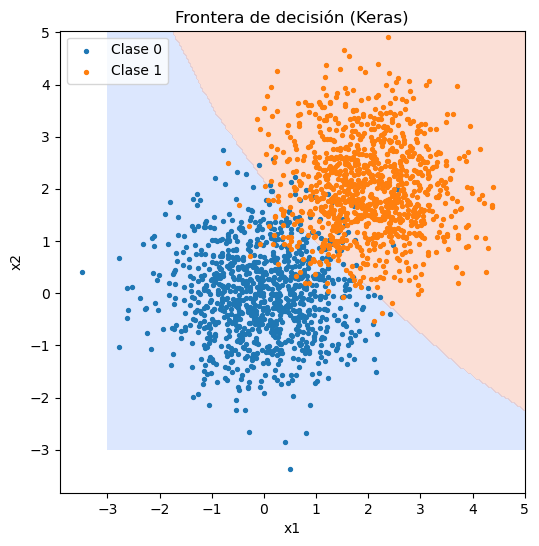

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1) Datos sintéticos
rng = np.random.default_rng(0)
n = 1000
cov = np.array([[0.8, 0.0],[0.0, 0.8]])
x0 = rng.multivariate_normal([0,0], cov, size=n)
x1 = rng.multivariate_normal([2,2], cov, size=n)
X = np.vstack([x0, x1]).astype("float32")
y = np.hstack([np.zeros(n), np.ones(n)]).astype("int32")

# 2) Modelo Keras
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax"),
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# 3) Entrenamiento
model.fit(X, y, epochs=40, batch_size=128, verbose=1)

# 4) Frontera de decisión
xs = np.linspace(-3, 5, 200)
ys = np.linspace(-3, 5, 200)
GX, GY = np.meshgrid(xs, ys)
grid = np.stack([GX.ravel(), GY.ravel()], axis=1).astype("float32")
Z = model.predict(grid, verbose=0).argmax(1).reshape(200,200)

plt.figure(figsize=(6,6))
plt.contourf(xs, ys, Z, alpha=0.3, levels=1, cmap="coolwarm")
plt.scatter(X[y==0,0], X[y==0,1], s=8, label="Clase 0")
plt.scatter(X[y==1,0], X[y==1,1], s=8, label="Clase 1")
plt.legend(); plt.title("Frontera de decisión (Keras)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.show()
